## MULTICOLLINEARITY ANALYSIS

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df = pd.read_excel("inventory_analy.xlsx")
df=df.drop("inventory", axis=1)
df.head()

,Proximity to marble,Proximity to mafic-ultramafic rocks,Proximity to granite-granodiorite,Proximity to monzonite,Proximity to faults,Lineament density,Iron-oxide alteration,Magnetic anomaly,Gravity anomaly
0,0,0,0,2,1,4,3,3,4
1,1,0,0,2,1,3,4,3,4
2,0,0,0,1,1,2,2,3,4
3,0,0,0,1,1,1,3,3,3
4,0,0,0,1,0,3,3,3,4


In [3]:
df_columns=df.columns

In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    for feature in features:
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        r2 = LinearRegression().fit(X, y).score(X, y)                
        tolerance[feature] = 1 - r2
        vif[feature] = 1/(tolerance[feature])
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})
calculate_vif(df=df, features=df_columns)

,VIF,Tolerance
Proximity to marble,9.406971,0.106304
Proximity to mafic-ultramafic rocks,1.777704,0.562523
Proximity to granite-granodiorite,4.346077,0.230093
Proximity to monzonite,6.222873,0.160697
Proximity to faults,9.735406,0.102718
Lineament density,1.763658,0.567003
Iron-oxide alteration,1.590338,0.628797
Magnetic anomaly,2.221859,0.450074
Gravity anomaly,5.590297,0.178881


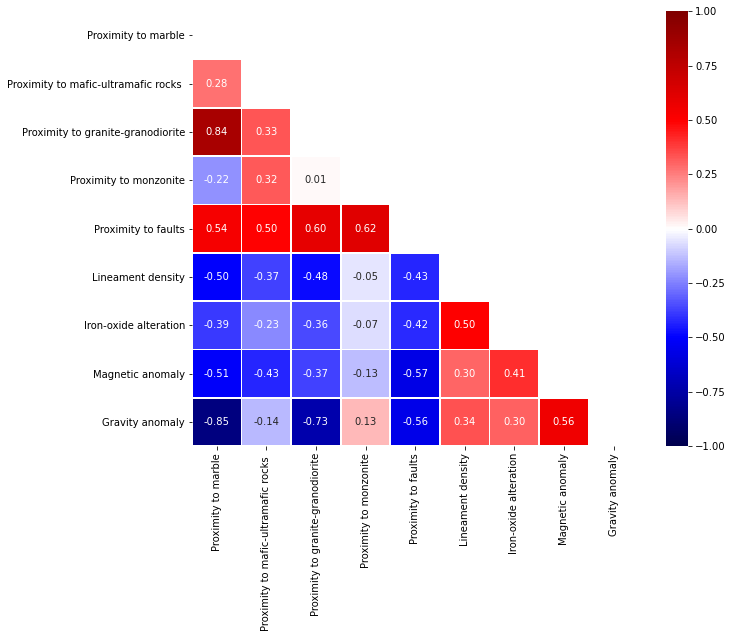

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='seismic', fmt=".2f", linewidths=0.8)
fig.savefig('pearson.jpg', dpi=150,bbox_inches='tight')

## DATA PREPROCESSING

In [6]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from ngboost import NGBClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, accuracy_score, recall_score, roc_curve, roc_auc_score, auc,precision_recall_curve, average_precision_score

In [7]:
df = pd.read_excel("inventory_analy.xlsx")

In [8]:
X = df.iloc[:,1:]
X.shape

(70, 9)

In [9]:
y = df.iloc[:,0].values
y.shape

(70,)

In [10]:
column_names = df.iloc[:,1:].columns
column_names

Index(['Proximity to marble', 'Proximity to mafic-ultramafic rocks ',
       'Proximity to granite-granodiorite', 'Proximity to monzonite',
       'Proximity to faults', 'Lineament density', 'Iron-oxide alteration',
       'Magnetic anomaly', 'Gravity anomaly'],
      dtype='object')

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=43, stratify=y)

## RANDOM FOREST CLASSIFICATION

In [12]:
RFC = RandomForestClassifier(random_state=42,n_estimators=50,criterion='gini', max_depth=50,
                            min_samples_split=2)
RFC.fit(X_train,y_train)

RandomForestClassifier(max_depth=50, n_estimators=50, random_state=42)

accuracy RFC:  0.8571428571428571
precision RFC:  0.8181818181818182
recall RFC:  0.9
f1 score RFC:  0.8571428571428572


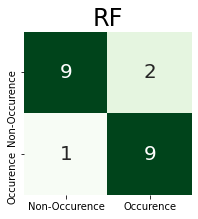

In [13]:
y_pred_RFC = RFC.predict(X_test)
df_cm_RFC= pd.DataFrame(confusion_matrix(y_test,y_pred_RFC), index = [i for i in ["Non-Occurence",  'Occurence']],columns = [i for i in ["Non-Occurence",  'Occurence']])
fig = plt.figure(figsize=(3, 3))
plt.title('RF', size=24)
sns.heatmap(df_cm_RFC, annot = True, fmt='g', cmap='Greens', cbar=False, annot_kws={"size": 20})
fig.savefig('conf_RF.png', dpi=150,bbox_inches='tight')

print("accuracy RFC: ", accuracy_score(y_test,y_pred_RFC)) 
print("precision RFC: ", precision_score(y_test,y_pred_RFC)) 
print("recall RFC: ", recall_score(y_test,y_pred_RFC)) 
print("f1 score RFC: ", f1_score(y_test,y_pred_RFC)) 

In [14]:
y_pred_prob_RFC = RFC.predict_proba(X_test)[:,1]
fpr_RFC, tpr_RFC, thresholds_RFC = roc_curve(y_test, y_pred_prob_RFC)
roc_auc_RFC = auc(fpr_RFC, tpr_RFC)

### Random Forest Feature Importance

In [15]:
fi_df = pd.DataFrame({
    "feature_importances" : RFC.feature_importances_,
    "features" : column_names
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)

fi_df

,feature_importances,features
0,0.214505,Proximity to marble
7,0.207835,Magnetic anomaly
2,0.168204,Proximity to granite-granodiorite
6,0.110247,Iron-oxide alteration
8,0.082358,Gravity anomaly
4,0.074815,Proximity to faults
1,0.066011,Proximity to mafic-ultramafic rocks
5,0.055893,Lineament density
3,0.020133,Proximity to monzonite


## GRADIENT BOOSTING CLASSIFICATION

In [16]:
GB= GradientBoostingClassifier(random_state=42,n_estimators=300, min_samples_split=2, learning_rate=0.1 )

GB.fit(X_train,y_train)

GradientBoostingClassifier(n_estimators=300, random_state=42)

accuracy GB:  0.8571428571428571
precision GB:  0.8181818181818182
recall GB:  0.9
f1 score GB:  0.8571428571428572


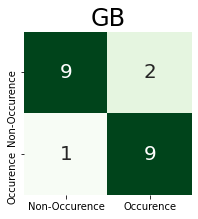

In [17]:
y_pred_GB = GB.predict(X_test)
df_cm_GB= pd.DataFrame(confusion_matrix(y_test,y_pred_GB), index = [i for i in ["Non-Occurence",  'Occurence']],columns = [i for i in ["Non-Occurence",  'Occurence']])

fig = plt.figure(figsize=(3, 3))
plt.title('GB', size=24)
sns.heatmap(df_cm_GB, annot = True, fmt='g', cmap='Greens', cbar=False, annot_kws={"size": 20})
fig.savefig('conf_GB.png', dpi=150,bbox_inches='tight')

print("accuracy GB: ", accuracy_score(y_test,y_pred_GB)) 
print("precision GB: ", precision_score(y_test,y_pred_GB)) 
print("recall GB: ", recall_score(y_test,y_pred_GB)) 
print("f1 score GB: ", f1_score(y_test,y_pred_GB)) 

In [18]:
y_pred_prob_GB = GB.predict_proba(X_test)[:,1]
fpr_GB, tpr_GB, thresholds_GB = roc_curve(y_test, y_pred_prob_GB)
roc_auc_GB = auc(fpr_GB, tpr_GB)

### Gradient Boosting Feature Importance

In [19]:
fi_df = pd.DataFrame({
    "feature_importances" : GB.feature_importances_,
    "features" : column_names
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)

fi_df

,feature_importances,features
0,0.539822,Proximity to marble
7,0.241250,Magnetic anomaly
5,0.152241,Lineament density
6,0.036926,Iron-oxide alteration
8,0.028028,Gravity anomaly
3,0.000855,Proximity to monzonite
2,0.000814,Proximity to granite-granodiorite
4,0.000039,Proximity to faults
1,0.000025,Proximity to mafic-ultramafic rocks


## XGBOOST CLASSIFICATION

In [20]:
XGB = xgb.XGBClassifier(random_state=42,eta=0.1, gamma=0.5, max_depth=10, use_label_encoder=False)

XGB.fit(X_train,y_train)

[13:01:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=0.1, gamma=0.5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.100000001,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

accuracy XGB:  0.8571428571428571
precision XGB:  0.8181818181818182
recall XGB:  0.9
f1 score XGB:  0.8571428571428572


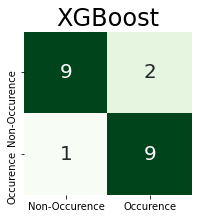

In [21]:
y_pred_XGB = XGB.predict(X_test)
df_cm_XGB= pd.DataFrame(confusion_matrix(y_test,y_pred_XGB), index = [i for i in ["Non-Occurence",  'Occurence']],columns = [i for i in ["Non-Occurence",  'Occurence']])
fig = plt.figure(figsize=(3, 3))
plt.title('XGBoost', size=24)
sns.heatmap(df_cm_XGB, annot = True, fmt='g', cmap='Greens', cbar=False, annot_kws={"size": 20})
fig.savefig('conf_XGB.png', dpi=150,bbox_inches='tight')

print("accuracy XGB: ", accuracy_score(y_test,y_pred_XGB)) 
print("precision XGB: ", precision_score(y_test,y_pred_XGB)) 
print("recall XGB: ", recall_score(y_test,y_pred_XGB)) 
print("f1 score XGB: ", f1_score(y_test,y_pred_XGB)) 

In [22]:
y_pred_prob_XGB = XGB.predict_proba(X_test)[:,1]
fpr_XGB, tpr_XGB, thresholds_XGB = roc_curve(y_test, y_pred_prob_XGB)
roc_auc_XGB = auc(fpr_XGB, tpr_XGB)

### XGBoost Feature Importance

In [23]:
fi_df = pd.DataFrame({
    "feature_importances" : XGB.feature_importances_,
    "features" : column_names
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)

fi_df

,feature_importances,features
0,0.339339,Proximity to marble
7,0.217977,Magnetic anomaly
8,0.122606,Gravity anomaly
2,0.119667,Proximity to granite-granodiorite
5,0.108508,Lineament density
6,0.061575,Iron-oxide alteration
4,0.030328,Proximity to faults
1,0.000000,Proximity to mafic-ultramafic rocks
3,0.000000,Proximity to monzonite


## LightGBM CLASSIFICATION

In [24]:
LGB = lgb.LGBMClassifier(random_state=42, max_depth=10,  boosting_type="dart", n_estimators=150, learning_rate=0.1)
LGB.fit(X_train,y_train)

LGBMClassifier(boosting_type='dart', max_depth=10, n_estimators=150,
               random_state=42)

accuracy LGB:  0.8571428571428571
precision LGB:  0.8181818181818182
recall LGB:  0.9
f1 score LGB:  0.8571428571428572


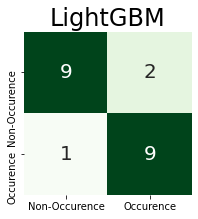

In [25]:
y_pred_LGB = LGB.predict(X_test)
df_cm_LGB= pd.DataFrame(confusion_matrix(y_test,y_pred_LGB), index = [i for i in ["Non-Occurence",  'Occurence']],columns = [i for i in ["Non-Occurence",  'Occurence']])
fig = plt.figure(figsize=(3, 3))
plt.title('LightGBM', size=24)
sns.heatmap(df_cm_LGB, annot = True, fmt='g', cmap='Greens', cbar=False, annot_kws={"size": 20})
fig.savefig('conf_LGB.png', dpi=150,bbox_inches='tight')

print("accuracy LGB: ", accuracy_score(y_test,y_pred_LGB)) 
print("precision LGB: ", precision_score(y_test,y_pred_LGB)) 
print("recall LGB: ", recall_score(y_test,y_pred_LGB)) 
print("f1 score LGB: ", f1_score(y_test,y_pred_LGB)) 

In [26]:
y_pred_prob_LGB = LGB.predict_proba(X_test)[:,1]
fpr_LGB, tpr_LGB, thresholds_LGB = roc_curve(y_test, y_pred_prob_LGB)
roc_auc_LGB = auc(fpr_LGB, tpr_LGB)

### LightGBM Feature Importance 

In [27]:
fi_df = pd.DataFrame({
    "feature_importances" : LGB.feature_importances_,
    "features" : column_names
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)


scalar = 100
fi_df['feature_importances'] = (fi_df['feature_importances'] / scalar)
fi_df

,feature_importances,features
2,0.44,Proximity to granite-granodiorite
0,0.43,Proximity to marble
7,0.22,Magnetic anomaly
6,0.15,Iron-oxide alteration
4,0.14,Proximity to faults
1,0.11,Proximity to mafic-ultramafic rocks
3,0.01,Proximity to monzonite
5,0.00,Lineament density
8,0.00,Gravity anomaly


## PERFORMANCE METRICS SUMMARY

In [28]:
rf_df = pd.DataFrame(data=[f1_score(y_test,y_pred_RFC),accuracy_score(y_test,y_pred_RFC), recall_score(y_test, y_pred_RFC),
                   precision_score(y_test,y_pred_RFC), roc_auc_RFC], 
             columns=['RF'],
             index=["F1 Score","Accuracy", "Recall", "Precision", "ROC AUC Score"])

gb_df = pd.DataFrame(data=[f1_score(y_test,y_pred_GB),accuracy_score(y_test, y_pred_GB), recall_score(y_test, y_pred_GB),
                   precision_score(y_test, y_pred_GB), roc_auc_GB], 
             columns=['GBM'],
             index=["F1 Score","Accuracy", "Recall", "Precision", "ROC AUC Score"])

xgb_df = pd.DataFrame(data=[f1_score(y_test,y_pred_XGB),accuracy_score(y_test, y_pred_XGB), recall_score(y_test, y_pred_XGB),
                   precision_score(y_test, y_pred_XGB), roc_auc_XGB], 
             columns=['XGBoost'],
             index=["F1 Score","Accuracy", "Recall", "Precision", "ROC AUC Score"])

lgb_df = pd.DataFrame(data=[f1_score(y_test,y_pred_LGB),accuracy_score(y_test, y_pred_LGB), recall_score(y_test, y_pred_LGB),
                   precision_score(y_test, y_pred_LGB), roc_auc_LGB], 
             columns=['LightGBM'],
             index=["F1 Score","Accuracy", "Recall", "Precision", "ROC AUC Score"])

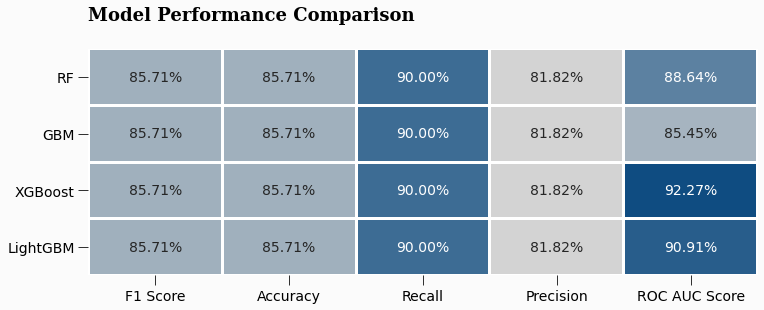

In [36]:
df_models = round(pd.concat([rf_df,gb_df,xgb_df,lgb_df], axis=1),4)
import matplotlib
colors = ["lightgray","lightgray","#0f4c81"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

background_color = "#fbfbfb"

fig = plt.figure(figsize=(12,10)) # create figure
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0.4, hspace=0.4)
ax0 = fig.add_subplot(gs[0, :])

sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".2%",vmin=0.75,vmax=0.92, linewidths=2,cbar=False,ax=ax0,annot_kws={"fontsize":14})
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color) 

ax0.text(0,-0.5,'Model Performance Comparison',fontsize=18,fontweight='bold',fontfamily='serif')

ax0.tick_params(axis=u'both', which=u'both',length=10, labelsize=14, labelrotation=0)

fig.savefig('performance_summary.png', dpi=300,bbox_inches='tight')
plt.show()

## SHAP ANALYSIS

In [37]:
import shap
shap.initjs()

### Global Explanation

In [42]:
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(X)

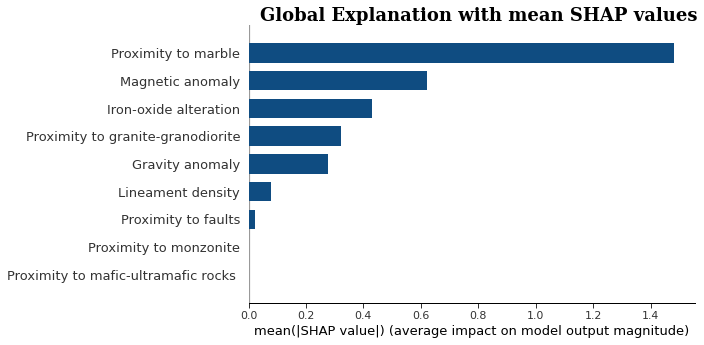

In [110]:
shap.summary_plot(shap_values, X, plot_type='bar',feature_names=column_names,show=False, color='#0f4c81')
plt.text(0.04,9.15,'Global Explanation with mean SHAP values',fontsize=18,fontweight='bold',fontfamily='serif')
fig.savefig('shap_XGB_global.png', dpi=150,bbox_inches='tight')

### Local Explanation

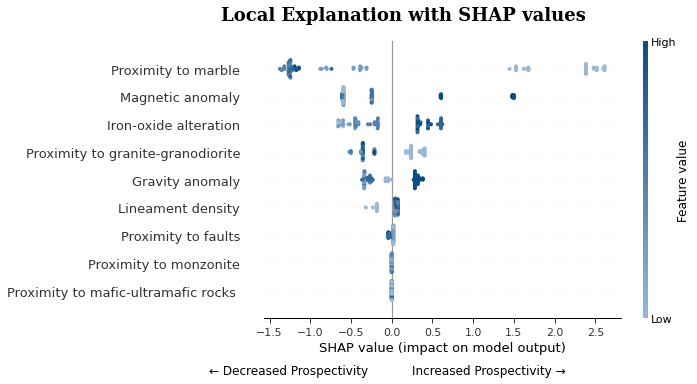

In [126]:
fig = plt.figure(figsize=(6, 6))
colors = ["#9bb7d4", "#0f4c81"]
import matplotlib.colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
#my_cmap = plt.get_cmap('bone_r')
shap.summary_plot(shap_values, features=X, feature_names=column_names, show=False)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(cmap)
plt.text(0.25, -3, 'Increased Prospectivity \u2192', fontsize=12, fontweight='ultralight')
plt.text(-2.25, -3, '\u2190 Decreased Prospectivity', fontsize=12, fontweight='ultralight')
plt.text(-2.1,9.75,'Local Explanation with SHAP values',fontsize=18,fontweight='bold',fontfamily='serif')
fig.savefig('shap_XGB_local.png', dpi=150,bbox_inches='tight')

invalid value encountered in true_divide
invalid value encountered in true_divide


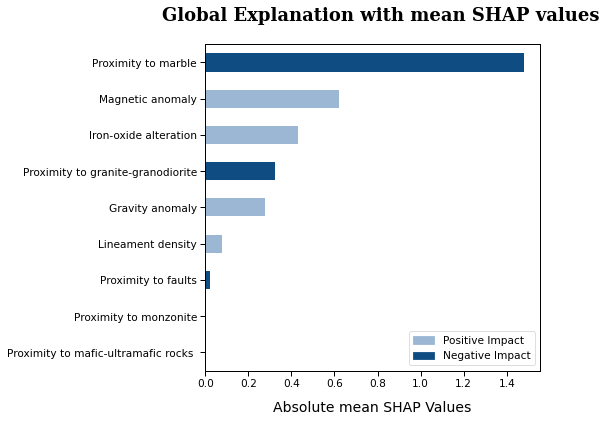

In [119]:
def ABS_SHAP(df_shap,df):
    import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    df = pd.DataFrame(df)
    feature_list = column_names
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'#9bb7d4','#0f4c81')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(6,6),legend=False)
    ax.set_xlabel("Absolute mean SHAP Values", fontsize=14, labelpad=12)
    ax.set_ylabel("", fontsize=14)
    import matplotlib.patches as mpatches
    lightblue_patch = mpatches.Patch(color='#9bb7d4', label='Positive Impact')
    darkblue_patch = mpatches.Patch(color='#0f4c81', label='Negative Impact')
    ax.legend(handles=[lightblue_patch,darkblue_patch], loc='lower right')
ABS_SHAP(shap_values, X)
plt.text(-0.2,9.15,'Global Explanation with mean SHAP values',fontsize=18,fontweight='bold',fontfamily='serif')
plt.savefig("abs_shap_xgb.png", dpi=150, bbox_inches='tight')

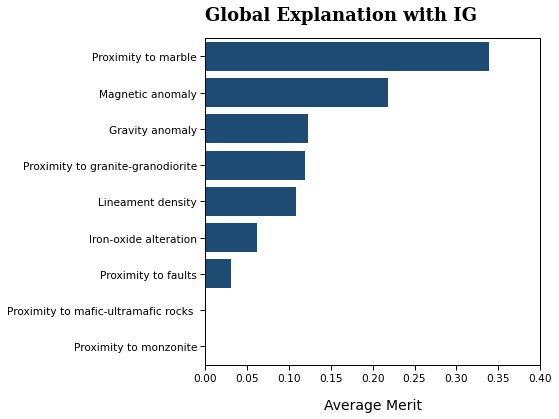

In [125]:

fi_df = pd.DataFrame({
    "feature_importances" : XGB.feature_importances_,
    "features" : column_names
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
sns.set_context('paper', font_scale = 1.2)
ax = sns.barplot(x="feature_importances", y="features", color="#0f4c81", data=fi_df, ci=None)
plt.xlabel("Average Merit",labelpad=15, size=14)
plt.ylabel("",labelpad=0, size=14)
plt.xlim(0.0, 0.40)
fig = plt.gcf()
fig.set_size_inches((6, 6), forward=False)
fig.savefig("IG_method.jpg", dpi=150)
plt.text(0,-1,'Global Explanation with IG',fontsize=18,fontweight='bold',fontfamily='serif')

plt.show()